**<h1><center>CS 464</center></h1>**
**<h1><center>Introduction to Machine Learning</center></h1>**
**<h1><center>Spring 2023</center></h1>**
**<h1><center>Homework 3</center></h1>**
<h4><center>Due: June 08, 2023 23:59 (GMT+3)</center></h4>

## **MNIST RGB Inpainting**

### **Homework Description**

In this assignment, you are asked to design and train two different neural network models for image the inpainting task. In short, inpainting is a process of filling in the missing parts of an image. You will be applying this task on the MNIST RGB dataset, which is created for this homework by processing a subset of the original [MNIST](http://yann.lecun.com/exdb/mnist/) images. It contains RGB digit images from 0 to 1 colored in black, red, blue, or green. You can see a subset of the dataset below. The download link of the dataset is provided in the following parts.

![MNIST RGB Samples](https://drive.google.com/uc?export=view&id=1uy0VENXeb6If-i3uxgDVtnk4qDj7eq_3)

**Using PyTorch is mandatory** for this assignment. You are requested to **submit only a single *.ipynb file** in your submissions (no report needed). If you want to provide further explanations about your work, you can add Markdown cells for this purpose. From [this link](https://www.markdownguide.org/), you can get familiar with the Markdown syntax if you need. Upload your homework with the following filename convention: **\<BilkentID\>\_\<Name\>\_\<Surname\>.ipynb**

Note that this assignment needs a CUDA-enabled GPU to be able to train the models in a reasonable time. If you do not have one, it is suggested to use the [Colab](https://colab.research.google.com/) environment.

**Contact:** [Ahmet Burak Yıldırım](mailto:a.yildirim@bilkent.edu.tr)

### **Importing the Libraries**

In the cell below,  some utilities that you can make use of in this assignment are imported. You can edit these imports considering your implementation as long as you use PyTorch.

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import os

### **Environment Check**

In the cell below, you can test whether hardware acceleration with GPU is enabled in your machine or not. If it is enabled, the printed device should be 'cuda'. 

**Do not change the cell**.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Current device:', device)

if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Current device: cpu


### **Setting Library Seeds for Reproducibility**

To make a fair evaluation, the seed values are set for random sampling methods in PyTorch, NumPy, and Python random library. 

**Do not change the cell**

In [3]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [4]:
seed_everything(464)

### **Preparing the Dataset**

The MNIST RGB dataset is downloadable from [this link](https://drive.google.com/file/d/1xl5Ie_1c3dIg-Y0uXsgbCYEEmDfQxadZ/view?usp=share_link). If you are using Colab or a Linux machine, you can uncomment and run the below cell to download and extract the dataset automatically.

In [5]:
'''
import gdown # Library to download files from Google Drive
!gdown 1xl5Ie_1c3dIg-Y0uXsgbCYEEmDfQxadZ # Google Drive ID of the zip file to be downloaded
!unzip -oq mnist_dataset_rgb # Unzip the file downloaded. Options -o and -q overwrites the files if exists already and disables printing out the extracted files, respectively.
'''

'\nimport gdown # Library to download files from Google Drive\n!gdown 1xl5Ie_1c3dIg-Y0uXsgbCYEEmDfQxadZ # Google Drive ID of the zip file to be downloaded\n!unzip -oq mnist_dataset_rgb # Unzip the file downloaded. Options -o and -q overwrites the files if exists already and disables printing out the extracted files, respectively.\n'

### **Implementing a Custom Dataset [20 Points]**

In this part, you are requested to implement a custom PyTorch dataset class that reads MNIST RGB images from a dataset split folder. There are two split folders called training and test in the dataset. The model class should take the root directory of a split in the \_\_init\_\_ function and read the images accordingly. Before returning the requested images, you should apply the following steps:

* Apply bicubic interpolation using PIL to resize the images from (28,28) to (32,32) resolution.
* Convert images to Tensor object
* Normalize tensor values to scale them in the range of (-1,1)

Note that reading images in the \_\_getitem\_\_ function makes the training process slow for this dataset because reading such small-sized images as a batch is slower than the forward pass process of a simple neural network. Therefore, it is suggested to read and store the images in an array in the \_\_init\_\_ function and return them in the \_\_getitem\_\_ function when they are requested by the DataLoader object.

In [6]:
class MnistDataset(Dataset):
    def __init__(self, root_dir):
        self.images = []
        class_names = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
        self.trans = transforms.Compose([
            transforms.ToTensor()])

        for class_id, class_name in enumerate(class_names): 
            class_dir = os.path.join(root_dir, class_name)
            image_files = os.listdir(class_dir)
            for file in tqdm(image_files):
                img = Image.open(class_dir+ '/' + file).resize((32,32), Image.BICUBIC)
                image_tensor = self.trans(img) # after this, shape is : [3, 32, 32]
                # Find the maximum and minimum values
                max_val = torch.max(image_tensor)
                min_val = torch.min(image_tensor)
                # Rescale values to the range (0, 1)
                new_image = (image_tensor - min_val) / (max_val - min_val)
                # Apply linear transformation to scale range to (-1, 1)
                new_image = (new_image * 2) - 1
                self.images.append(new_image)


    def __len__(self):
        return len(self.images)

    def __getitem__(self, data_id):
        return self.images[data_id]

Create a dataset and a data loader object for training and test splits. Set batch sizes to 64 and 512 for training and test data loaders, respectively. Enable shuffling in the training data loader and disable it in the test data loader.

In [7]:
train_dataset = MnistDataset(root_dir='./mnist_dataset_rgb/training')
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = MnistDataset(root_dir='./mnist_dataset_rgb/test')
test_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=False)

100%|██████████| 1009/1009 [00:00<00:00, 5372.85it/s]


**Do not change** the below code. If your implementation is correct, you should be seeing a grid of MNIST RGB images properly.

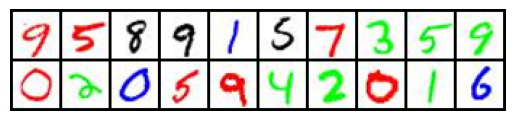

In [8]:
## Uncomment the cell when the dataloader is ready

images = next(iter(train_dataloader))
images = (images + 1) / 2
grid_img = torchvision.utils.make_grid(images[:20], nrow=10)
plt.axis('off')
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

### **Constructing Autoencoder Networks [30 Points]**

Autoencoder networks learn how to compress and reconstruct input data. It consists of two subnetworks called the encoder and the decoder. The encoder network compresses the input data, and the decoder network regenerates the data from its compressed version. In this part of the homework, you are requested to implement two different autoencoder networks, which are fully connected and convolutional autoencoders.

#### **Fully Connected Autoencoder [15 Points]**

Fully connected networks consist of multiple [linear layers](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html). The figure of the architecture is provided below, where the number of nodes is kept small for simplification. 

![Fully Connected Autoencoder Architecture](https://drive.google.com/uc?export=view&id=1JeDQtjvWVoT5dZhVxesQp_XiqAnUvi1i)

In this part, you are requested to implement the layers and the forward function of the model. You should flatten the input image before feeding it to the network and unflatten it when the final activations are obtained. The (input_size, output_size) pairs of the layers should be defined as follows:

**Encoder:**
- (3\*32\*32, 256)
- (256, 64)
- (64, 16)

**Decoder:**
- (16, 64)
- (64, 256)
- (256, 3\*32\*32)

In each layer, [1D batch normalization](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html) should be applied and the resulting values should be passed through a LeakyReLU layer with slope 0.2, which is the activation function. Since the image pixel value range is set to [-1,1] in the dataset, the outputs should be bounded so. Therefore, you should be using a Tanh activation function in the last layer instead of the normalization and LeakyReLU layers.

In [9]:
class MnistAutoencoderFC(nn.Module):
    def __init__(self):
        super(MnistAutoencoderFC, self).__init__()

        self.flatten = nn.Flatten()

        self.encode_1 = nn.Sequential(
            nn.Linear(in_features=3072, out_features=256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
        )
        self.encode_2 = nn.Sequential(
            nn.Linear(in_features=256, out_features=64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2),
        )
        self.encode_3 = nn.Sequential(
            nn.Linear(in_features=64, out_features=16),
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.2),
        )

        self.decode_1 = nn.Sequential(
            nn.Linear(in_features=16, out_features=64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2),
        )
        self.decode_2 = nn.Sequential(
            nn.Linear(in_features=64, out_features=256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
        )
        self.decode_3 = nn.Sequential(
            nn.Linear(in_features=256, out_features=3072),
            nn.Tanh()
        )
       

    def forward(self, x):
        x = self.flatten(x)
        x = self.encode_1(x)
        x = self.encode_2(x)
        x = self.encode_3(x)
        x = self.decode_1(x)
        x = self.decode_2(x)
        x = self.decode_3(x)
        x = x.reshape(-1, 3, 32, 32)
        return x

#### **Convolutional Autoencoder [15 Points]**

In this part, you are requested to implement an autoencoder model using convolutional layers. The architecture of a convolutional autoencoder is shown in the below figure.

![Convolutional Autoencoder Architecture](https://drive.google.com/uc?export=view&id=18Ztf-zhMFC_IXDTnvGCUeGgZx-7duu0o)

 The (in_channel, out_channel) pairs of the layers should be defined as follows:

**Encoder:**
- (3, 16)
- (16, 32)
- (32, 64)

**Decoder:**
- (64, 32)
- (32, 16)
- (16, 3)

You are free to choose the kernel and padding sizes of the layers. In each layer, [2D batch normalization](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html) should be applied and the resulting values should be passed through a LeakyReLU layer with slope 0.2, which is the activation function. Since the image pixel value range is set to [-1,1] in the dataset, the outputs should be bounded so. Therefore, you should be using a Tanh activation function in the last layer instead of the normalization and LeakyReLU layers. 

In the encoder part of the network, use max pooling in each layer for decreasing the resolution. The stride size should be set to one in these layers. In the decoder network, use [transposed convolution](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) (deconvolution) layers with stride two for increasing the resolution back. 

In [10]:
class MnistAutoencoderConv(nn.Module):
    def __init__(self):
        super(MnistAutoencoderConv, self).__init__()
        
        self.encode_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.encode_2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )       
        self.encode_3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.decode_1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, padding=1, output_padding=1, stride=2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
        )
        self.decode_2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, padding=1, output_padding=1, stride=2),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
        )
        self.decode_3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=3, padding=1, output_padding=1, stride=2),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encode_1(x)
        x = self.encode_2(x)
        x = self.encode_3(x)
        x = self.decode_1(x)
        x = self.decode_2(x)
        x = self.decode_3(x)
        return x

### **Implementing the Training Loop [15 Points]**

Define your training loop in this function. In the following parts, this function will be called to train both the fully connected and the convolutional autoencoders. The input arguments are provided below. Apply the training progress and return a list of losses that are calculated on each epoch. You should sum the iteration losses up during an epoch and take the mean of them to calculate the running loss of that epoch.

To be able to learn inpainting, you should mask the input images as follows:

![MNIST Masking](https://drive.google.com/uc?export=view&id=1gIELbRSE188PQHv_uGktPX_2cvAtMbN-)

Simply, you should set the input tensor columns starting from 16 to 32 as -1 (black pixel). For the loss function, you should use the original image as the ground truth image so that the network learns how to fill the masked area of the input image and output the restored image. Before assigning the black pixels, do not forget to clone the original image to use it later in the loss function.

In [11]:
iter_losses = []
epoch_losses = []
outputs = []

In [12]:
def train_model(model, train_dataloader, optimizer, loss_func, num_epochs):
    num_batches = len(train_dataloader)
    for epoch in tqdm(range(num_epochs)):
        total_iter_loss = 0.0
        for data in tqdm(train_dataloader, desc=f"Epoch: {epoch+1}", total=num_batches, position=0, leave=True):
            optimizer.zero_grad()
            # set half of the images to black
            train_images = data.clone()
            train_images[:, :, :, 16:32] = -1.0
            if device.type == 'cuda':
                data = data.cuda()
                train_images = train_images.cuda()
            batch_output = model(train_images)
            outputs.append(batch_output)
            loss = loss_func(batch_output, data)
            loss.backward()
            optimizer.step()

            iter_losses.append(loss.item())
            total_iter_loss += loss.item()
        epoch_loss = total_iter_loss / num_batches
        epoch_losses.append(epoch_loss)
        print(f"\nEpoch {epoch+1} Loss: {epoch_loss}")

    print("Training is finished!")

### **Implementing the Evaluation Function [15 Points]**

Implement an evaluation function that returns the mean MSE calculated over the test dataset samples.

In [13]:
def evaluate_model(model, test_dataloader):
    mse_total = 0
    loss = nn.MSELoss()
    model.eval()
    with torch.no_grad():
        for data in tqdm(test_dataloader):
            test_images = data.clone()
            test_images[:, :, :, 16:32] = -1.0
            if device.type == 'cuda':
                data = data.cuda()
                test_images = test_images.cuda()
            test_result = model(test_images)
            mse = loss(test_result, data)
            mse_total += mse.item()
    
    return mse_total / len(test_dataloader)

### **Inpainting Visualization Function**

The below code will be used to visualize the outputs of the trained models later. 

**Do not change the cell**

In [14]:
def visualize_inpainting(model, dataset):
    seed_everything(464)
    dataloader = DataLoader(dataset, batch_size=10, shuffle=True)
    images = next(iter(dataloader)) # Taking one batch from the dataloader
    images = images
    model.eval()
    with torch.no_grad():
      masked_images = images.clone()
      masked_images[:,:,:,16:] = -1
      if device.type == 'cuda':
        inpainted_images = model(masked_images.cuda()).cpu()
      else:
        inpainted_images = model(masked_images).cpu()
    images = (images + 1) / 2
    masked_images = (masked_images + 1) / 2
    inpainted_images = (inpainted_images + 1) / 2
    images_concat = torch.cat((images, masked_images, inpainted_images), dim=2)
    grid_img = torchvision.utils.make_grid(images_concat, nrow=10)
    plt.axis('off')
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()

### **Training and Evaluating the FC Model [5 Points]**

Define your loss function as MSE, set learning rate to 2e-4, create Adam optimizer, and set number of epochs to 50. Later, call the train_model function that you implemented. Visualize the returned losses on a plot (loss vs. epoch). Lastly, call evaluate_model function that you implemented and print the accuracy the model reached on the test dataset. Also, call the visualize_inpainting function to observe the final inpainting results on the test dataset.



In [15]:
seed_everything(464)
model_fc = MnistAutoencoderFC() ## Uncomment when the model is implemented
if device.type == 'cuda':
    model_fc.cuda()
loss_func = nn.MSELoss()
optimizer = optim.Adam(model_fc.parameters(), lr=2e-4)
train_model(model_fc, train_dataloader, optimizer, loss_func, 50)

  2%|▏         | 1/50 [00:05<04:22,  5.36s/it]


Epoch 1 Loss: 0.14001298246100125


  4%|▍         | 2/50 [00:10<04:06,  5.14s/it]


Epoch 2 Loss: 0.07570980008586746


  6%|▌         | 3/50 [00:15<03:57,  5.06s/it]


Epoch 3 Loss: 0.06830200110859883


  8%|▊         | 4/50 [00:20<03:49,  4.98s/it]


Epoch 4 Loss: 0.0643444227202393


 10%|█         | 5/50 [00:24<03:40,  4.90s/it]


Epoch 5 Loss: 0.06174863712466739


 12%|█▏        | 6/50 [00:29<03:35,  4.90s/it]


Epoch 6 Loss: 0.05984728177890296


 14%|█▍        | 7/50 [00:34<03:29,  4.88s/it]


Epoch 7 Loss: 0.0582632612999138


 16%|█▌        | 8/50 [00:39<03:29,  4.98s/it]


Epoch 8 Loss: 0.05705018408234467


 18%|█▊        | 9/50 [00:44<03:22,  4.95s/it]


Epoch 9 Loss: 0.056106793544138486


 20%|██        | 10/50 [00:49<03:15,  4.89s/it]


Epoch 10 Loss: 0.055145623171916396


 22%|██▏       | 11/50 [00:54<03:09,  4.85s/it]


Epoch 11 Loss: 0.05424180902216746


 24%|██▍       | 12/50 [00:59<03:03,  4.82s/it]


Epoch 12 Loss: 0.053655132127311225


 26%|██▌       | 13/50 [01:03<02:57,  4.81s/it]


Epoch 13 Loss: 0.05298192721917806


 28%|██▊       | 14/50 [01:09<03:01,  5.05s/it]


Epoch 14 Loss: 0.05242459525537613


 30%|███       | 15/50 [01:14<02:55,  5.03s/it]


Epoch 15 Loss: 0.051878233809414726


 32%|███▏      | 16/50 [01:19<02:49,  4.97s/it]


Epoch 16 Loss: 0.05144680576765781


 34%|███▍      | 17/50 [01:24<02:43,  4.95s/it]


Epoch 17 Loss: 0.05091220373406892


 36%|███▌      | 18/50 [01:28<02:37,  4.91s/it]


Epoch 18 Loss: 0.050666423300114435


 38%|███▊      | 19/50 [01:33<02:31,  4.90s/it]


Epoch 19 Loss: 0.050223705847092605


 40%|████      | 20/50 [01:38<02:26,  4.88s/it]


Epoch 20 Loss: 0.04984586570612


 42%|████▏     | 21/50 [01:43<02:21,  4.88s/it]


Epoch 21 Loss: 0.04951464763992583


 44%|████▍     | 22/50 [01:48<02:16,  4.89s/it]


Epoch 22 Loss: 0.04928103894890879


 46%|████▌     | 23/50 [01:53<02:11,  4.87s/it]


Epoch 23 Loss: 0.04897734569504743


 48%|████▊     | 24/50 [01:58<02:06,  4.88s/it]


Epoch 24 Loss: 0.04866585870990363


 50%|█████     | 25/50 [02:03<02:02,  4.88s/it]


Epoch 25 Loss: 0.04835914708483402


 52%|█████▏    | 26/50 [02:07<01:56,  4.87s/it]


Epoch 26 Loss: 0.04823493050492328


 54%|█████▍    | 27/50 [02:12<01:51,  4.86s/it]


Epoch 27 Loss: 0.04795275764811374


 56%|█████▌    | 28/50 [02:17<01:47,  4.87s/it]


Epoch 28 Loss: 0.04778559694109518


 58%|█████▊    | 29/50 [02:22<01:42,  4.87s/it]


Epoch 29 Loss: 0.04757588875510961


 60%|██████    | 30/50 [02:27<01:37,  4.86s/it]


Epoch 30 Loss: 0.047351915737056674


 62%|██████▏   | 31/50 [02:34<01:43,  5.43s/it]


Epoch 31 Loss: 0.04719134808406043


 64%|██████▍   | 32/50 [02:38<01:34,  5.23s/it]


Epoch 32 Loss: 0.046976690711763205


 66%|██████▌   | 33/50 [02:43<01:26,  5.09s/it]


Epoch 33 Loss: 0.04678668309946347


 68%|██████▊   | 34/50 [02:50<01:28,  5.55s/it]


Epoch 34 Loss: 0.04659257030776699


 70%|███████   | 35/50 [02:55<01:20,  5.37s/it]


Epoch 35 Loss: 0.0464529703035379


 72%|███████▏  | 36/50 [03:00<01:13,  5.22s/it]


Epoch 36 Loss: 0.046332344198432726


 74%|███████▍  | 37/50 [03:04<01:06,  5.10s/it]


Epoch 37 Loss: 0.04615931609250091


 76%|███████▌  | 38/50 [03:09<01:00,  5.02s/it]


Epoch 38 Loss: 0.04600580927470456


 78%|███████▊  | 39/50 [03:14<00:54,  4.96s/it]


Epoch 39 Loss: 0.04584987529212861


 80%|████████  | 40/50 [03:19<00:49,  4.92s/it]


Epoch 40 Loss: 0.04563783668934384


 82%|████████▏ | 41/50 [03:24<00:44,  4.90s/it]


Epoch 41 Loss: 0.0456191187443407


 84%|████████▍ | 42/50 [03:29<00:39,  4.89s/it]


Epoch 42 Loss: 0.04550449990803171


 86%|████████▌ | 43/50 [03:33<00:34,  4.88s/it]


Epoch 43 Loss: 0.04537854564216588


 88%|████████▊ | 44/50 [03:38<00:29,  4.87s/it]


Epoch 44 Loss: 0.04524967860420952


 90%|█████████ | 45/50 [03:43<00:24,  4.93s/it]


Epoch 45 Loss: 0.04517005529264202


 92%|█████████▏| 46/50 [03:48<00:19,  4.92s/it]


Epoch 46 Loss: 0.04501692625834509


 94%|█████████▍| 47/50 [03:53<00:14,  4.95s/it]


Epoch 47 Loss: 0.04493538339805725


 96%|█████████▌| 48/50 [03:58<00:09,  4.95s/it]


Epoch 48 Loss: 0.04484602901846399


 98%|█████████▊| 49/50 [04:03<00:04,  4.92s/it]


Epoch 49 Loss: 0.044678450169046514


100%|██████████| 50/50 [04:08<00:00,  4.97s/it]


Epoch 50 Loss: 0.04466932245037135
Training is finished!


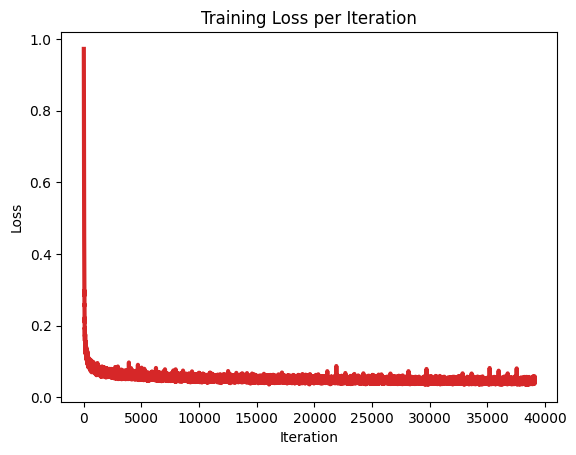

In [16]:
plt.plot(range(len(iter_losses)), iter_losses, color="tab:red", linewidth=3)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss per Iteration")
plt.show()

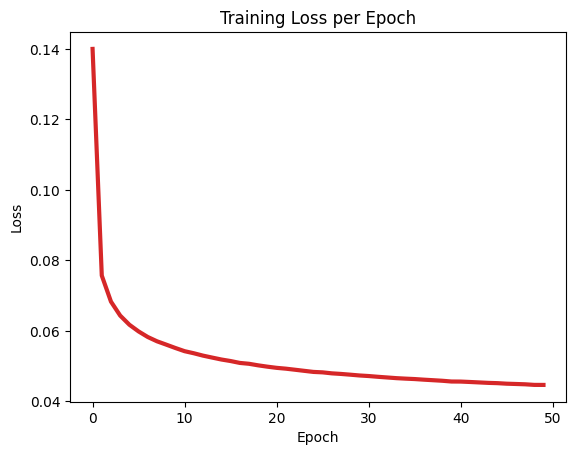

In [17]:
plt.plot(range(len(epoch_losses)), epoch_losses, color="tab:red", linewidth=3)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss per Epoch")
plt.show()

In [18]:
evaluate_model(model_fc, test_dataloader)

100%|██████████| 98/98 [00:00<00:00, 161.37it/s]


0.04042871593858818

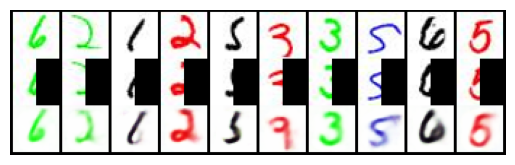

In [19]:
visualize_inpainting(model_fc, test_dataset) ## Uncomment when the model is trained

In [20]:
iter_losses.clear()
epoch_losses.clear()
outputs.clear()

### **Training and Evaluating the Convolutional Model [5 Points]**

Apply the same steps given in the FC Autoencoder part.

In [21]:
seed_everything(464)
model_conv = MnistAutoencoderConv() ## Uncomment when the model is implemented
if device.type == 'cuda':
    model_conv.cuda()
loss_func = nn.MSELoss()
optimizer = optim.Adam(model_conv.parameters(), lr=2e-4)
train_model(model_conv, train_dataloader, optimizer, loss_func, 50)

  2%|▏         | 1/50 [00:36<29:54, 36.62s/it]


Epoch 1 Loss: 0.30102179581513794


  4%|▍         | 2/50 [01:12<28:47, 36.00s/it]


Epoch 2 Loss: 0.08625917082361857


  6%|▌         | 3/50 [01:47<28:02, 35.79s/it]


Epoch 3 Loss: 0.06977069998145713


  8%|▊         | 4/50 [02:24<27:38, 36.05s/it]


Epoch 4 Loss: 0.06435015296463466


 10%|█         | 5/50 [03:01<27:24, 36.54s/it]


Epoch 5 Loss: 0.06137289235468411


 12%|█▏        | 6/50 [03:37<26:39, 36.36s/it]


Epoch 6 Loss: 0.05926748313238401


 14%|█▍        | 7/50 [04:14<26:12, 36.57s/it]


Epoch 7 Loss: 0.05775165222013545


 16%|█▌        | 8/50 [04:50<25:29, 36.42s/it]


Epoch 8 Loss: 0.056481024831571545


 18%|█▊        | 9/50 [05:26<24:39, 36.07s/it]


Epoch 9 Loss: 0.05547020238969485


 20%|██        | 10/50 [06:01<23:58, 35.96s/it]


Epoch 10 Loss: 0.054671576070358684


 22%|██▏       | 11/50 [06:38<23:29, 36.15s/it]


Epoch 11 Loss: 0.053901476861761353


 24%|██▍       | 12/50 [07:14<22:50, 36.05s/it]


Epoch 12 Loss: 0.053245079796523084


 26%|██▌       | 13/50 [07:49<22:06, 35.85s/it]


Epoch 13 Loss: 0.052639679706957945


 28%|██▊       | 14/50 [08:25<21:26, 35.75s/it]


Epoch 14 Loss: 0.0521664698905957


 30%|███       | 15/50 [09:00<20:51, 35.75s/it]


Epoch 15 Loss: 0.05167933088986922


 32%|███▏      | 16/50 [09:36<20:12, 35.67s/it]


Epoch 16 Loss: 0.05127680079673257


 34%|███▍      | 17/50 [10:12<19:39, 35.74s/it]


Epoch 17 Loss: 0.050870258237242394


 36%|███▌      | 18/50 [10:47<19:04, 35.76s/it]


Epoch 18 Loss: 0.05055409514099893


 38%|███▊      | 19/50 [11:23<18:26, 35.71s/it]


Epoch 19 Loss: 0.050267650838703146


 40%|████      | 20/50 [12:00<18:01, 36.06s/it]


Epoch 20 Loss: 0.05000870269925698


 42%|████▏     | 21/50 [12:38<17:40, 36.58s/it]


Epoch 21 Loss: 0.049732396036119716


 44%|████▍     | 22/50 [13:15<17:13, 36.91s/it]


Epoch 22 Loss: 0.04942520446313159


 46%|████▌     | 23/50 [13:53<16:46, 37.26s/it]


Epoch 23 Loss: 0.049243103855711116


 48%|████▊     | 24/50 [14:31<16:07, 37.20s/it]


Epoch 24 Loss: 0.04907149872016114


 50%|█████     | 25/50 [15:07<15:23, 36.96s/it]


Epoch 25 Loss: 0.04883163754859239


 52%|█████▏    | 26/50 [15:43<14:42, 36.79s/it]


Epoch 26 Loss: 0.048681585975658255


 54%|█████▍    | 27/50 [16:21<14:09, 36.93s/it]


Epoch 27 Loss: 0.048471924755960474


 56%|█████▌    | 28/50 [16:58<13:32, 36.94s/it]


Epoch 28 Loss: 0.04833252927112153


 58%|█████▊    | 29/50 [17:35<12:56, 36.98s/it]


Epoch 29 Loss: 0.04818239439840969


 60%|██████    | 30/50 [18:11<12:15, 36.78s/it]


Epoch 30 Loss: 0.04806134360544669


 62%|██████▏   | 31/50 [18:47<11:36, 36.65s/it]


Epoch 31 Loss: 0.047885773674873136


 64%|██████▍   | 32/50 [19:24<10:58, 36.59s/it]


Epoch 32 Loss: 0.04773800279421117


 66%|██████▌   | 33/50 [20:00<10:21, 36.57s/it]


Epoch 33 Loss: 0.04769396504191944


 68%|██████▊   | 34/50 [20:37<09:44, 36.56s/it]


Epoch 34 Loss: 0.0475140891140303


 70%|███████   | 35/50 [21:13<09:08, 36.55s/it]


Epoch 35 Loss: 0.04742100720515337


 72%|███████▏  | 36/50 [21:50<08:32, 36.57s/it]


Epoch 36 Loss: 0.04731859965607181


 74%|███████▍  | 37/50 [22:26<07:54, 36.51s/it]


Epoch 37 Loss: 0.0471760962453797


 76%|███████▌  | 38/50 [23:03<07:18, 36.57s/it]


Epoch 38 Loss: 0.04709097892141251


 78%|███████▊  | 39/50 [23:41<06:46, 36.93s/it]


Epoch 39 Loss: 0.04701415996741303


 80%|████████  | 40/50 [24:19<06:11, 37.18s/it]


Epoch 40 Loss: 0.04688846078865668


 82%|████████▏ | 41/50 [24:56<05:35, 37.23s/it]


Epoch 41 Loss: 0.04682490951322076


 84%|████████▍ | 42/50 [25:33<04:58, 37.33s/it]


Epoch 42 Loss: 0.04678653272540521


 86%|████████▌ | 43/50 [26:11<04:21, 37.41s/it]


Epoch 43 Loss: 0.04661153469834944


 88%|████████▊ | 44/50 [26:48<03:44, 37.40s/it]


Epoch 44 Loss: 0.0465638831095851


 90%|█████████ | 45/50 [27:27<03:08, 37.66s/it]


Epoch 45 Loss: 0.046500528083585416


 92%|█████████▏| 46/50 [28:05<02:31, 37.80s/it]


Epoch 46 Loss: 0.0464030485886061


 94%|█████████▍| 47/50 [28:43<01:54, 38.04s/it]


Epoch 47 Loss: 0.04634075769035103


 96%|█████████▌| 48/50 [29:23<01:16, 38.40s/it]


Epoch 48 Loss: 0.04627055511869433


 98%|█████████▊| 49/50 [30:00<00:38, 38.07s/it]


Epoch 49 Loss: 0.046179921402002846


100%|██████████| 50/50 [30:38<00:00, 36.78s/it]


Epoch 50 Loss: 0.046146986453467626
Training is finished!


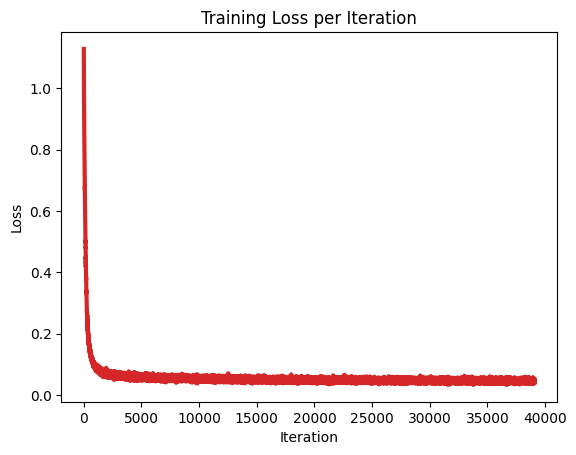

In [22]:
plt.plot(range(len(iter_losses)), iter_losses, color="tab:red", linewidth=3)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss per Iteration")
plt.show()

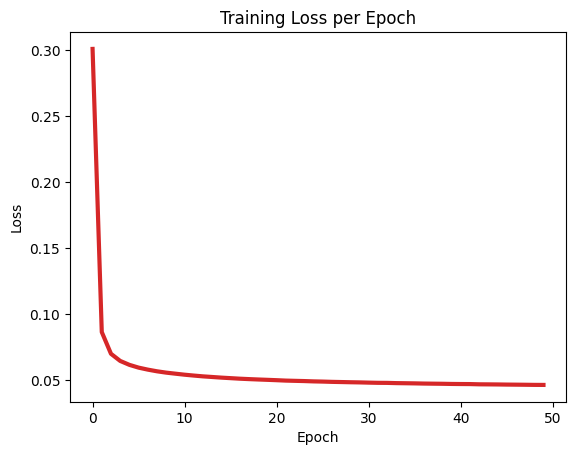

In [23]:
plt.plot(range(len(epoch_losses)), epoch_losses, color="tab:red", linewidth=3)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss per Epoch")
plt.show()

In [24]:
evaluate_model(model_conv, test_dataloader)

100%|██████████| 98/98 [00:07<00:00, 12.43it/s]


0.04572483148349791

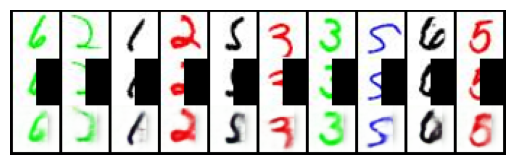

In [25]:
visualize_inpainting(model_conv, test_dataset) ## Uncomment when the model is trained

### **Discussion [10 Points]**

Discuss the results that you obtained after training the models. Compare the inpainting performances by the visualizations and the accuracy metrics. You can write your answer in the below cell.

I believe that for both of the models, I was successfully able to train, use, and evaluate them. For the training process, as can be seen in the above outputs and plots, the training loss decreased with every iteration. However, I believe that the loss are not yet at point of convergence. If I could modify some of the hyperparameters such as the learning rate, batch size, or increase the epoch; I maybe could have achieved a better training loss. But this could also be problematic as I could have overfitted the model (for example if I were to increse the epoch), hence, I would chose some portion of the training set as validation set, then observe performances of different combinations of parameters in order to come up with the ideal model (I would basically do hyperparameter tuning).

But overall, I think both of these models are great as they give around 0.04 (FC model) and 0.045 (CNN model) MSE loss when they are evaluated on the test data. This can be observed on the visualization of the final models as well. I think both models do a great job in filling the missing parts of the digits. For most of the cases, they seem to be filling the missing part in a way that the total picture represents the correct digit.

Looking more deeply at the visualizations though, the CNN model seemed to perfom better on one or two images, for example the "red coloured 3". The FC model filled the rest of the image as it is a 9 instead of a 3. However, I think this is just specific to that example of data and its spesific patterns, because since the FC model has a better evaluation MSE, normally one would except it to perform better.

There might be several reasons why the FC model has a better final MSE loss value. As I mentioned above, the chosen parameters may have played an important role in this, but apart from those, it might be related to our dataset. Since our dataset contains simple and not so complex patterns, a FC model might be sufficient to capture the necessary information for the inpainting task. CNN models excel in tasks that involve capturing more spatial structures (and spacial structures do not play that much of a crucial role here as our images are simply digits on top of a white background) and more complex patterns, which could have been more effective if we dealt with more complex images.